<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-feature_engineering_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1
!pip install wandb==0.13.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution foun

In [2]:
import os
import random

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
import pandas as pd

import seaborn as sns

from tqdm.notebook import tqdm
import wandb

In [3]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")
dataset = wandb.Artifact(name='train_val_test', type="preprocessed_data")

wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"

In [5]:
# set fixed seed
def seed_everything(seed): 
  """ 
  Seeds basic parameters for reproducibility of results 
  """ 
  os.environ["PYTHONHASHSEED"] = str(seed) 
  random.seed(seed)

seed = 42
seed_everything(seed)

In [6]:
train = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet")

In [7]:
train.head(10)

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
5,YHOO,2005-05-02 09:30:03,73595,YHQ,2005-10-22,35.0,P,26,3.00,2.95,...,2.90,1133.0,256.0,3.10,3.40,24020608.0,46.0,3.10,3.40,-1
6,MATK,2005-05-02 09:30:03,80182,KQT,2005-09-17,65.0,C,2,0.55,0.30,...,0.30,56.0,10.0,0.45,0.45,23989792.0,2.0,0.65,0.45,1
7,VTSS,2005-05-02 09:30:04,80469,VQT,2005-10-22,5.0,P,10,2.75,2.70,...,2.70,10.0,52.0,2.90,2.90,24019950.0,40.0,2.90,2.90,-1
8,ADRX,2005-05-02 09:30:04,80342,QAX,2005-09-17,25.0,C,1,0.60,0.45,...,0.45,94.0,25.0,0.55,0.50,23983374.0,11.0,0.65,0.50,1
9,IVGN,2005-05-02 09:30:04,97063,IUV,2005-08-20,65.0,C,10,11.00,0.00,...,NaN,NaN,NaN,13.80,9.90,23797976.0,10.0,13.80,9.90,1


In [8]:
# randomly sample 10 % of rows
train = train.sample(frac=0.1, random_state=seed)

In [9]:
# calculate days to maturity
train['time_to_maturity'] = (train['EXPIRATION'] - train['QUOTE_DATETIME']).dt.days

In [10]:
train.dtypes

UNDERLYING_SYMBOL            object
QUOTE_DATETIME       datetime64[ns]
SEQUENCE_NUMBER               int64
ROOT                         object
EXPIRATION           datetime64[ns]
STRK_PRC                    float32
OPTION_TYPE                category
TRADE_SIZE                    int64
TRADE_PRICE                 float32
BEST_BID                    float32
BEST_ASK                    float32
order_id                      int64
ask_ex                      float32
bid_ex                      float32
bid_size_ex                 float32
ask_size_ex                 float32
price_all_lead              float32
price_all_lag               float32
optionid                    float32
day_vol                     float32
price_ex_lead               float32
price_ex_lag                float32
buy_sell                       int8
time_to_maturity              int64
dtype: object

In [11]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = train.select_dtypes(include=['category', 'object']).columns.tolist()
print(cat_columns)

# binarize categorical similar to Borisov et al.
train[cat_columns] = train[cat_columns].apply(lambda x : pd.factorize(x)[0])

['UNDERLYING_SYMBOL', 'ROOT', 'OPTION_TYPE']


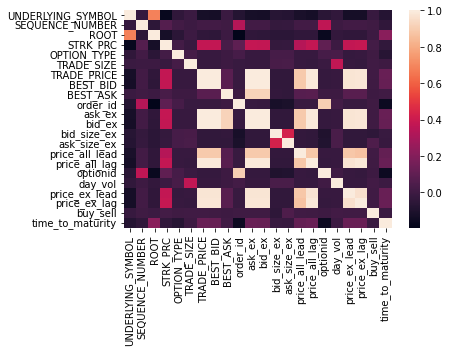

In [14]:
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [15]:
# remove problematic features -> see notebook on aversarial validation
train = train.drop(["SEQUENCE_NUMBER", "order_id", "optionid", "EXPIRATION", "QUOTE_DATETIME", "ROOT"], axis=1)

In [18]:
# isolate target
y = train[["buy_sell"]]
train = train.drop(["buy_sell"], axis=1)

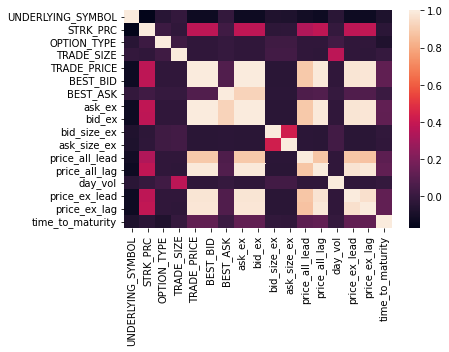

In [19]:
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
y = train[["buy_sell"]]
train.drop(["buy_sell"], axis=1)

In [ ]:
# TODO: Add midspread feature

In [ ]:
# TODO: Calculate rel distance from mid

In [ ]:
# TODO: Degree how much Trade size is filled (-1 to 1)

In [ ]:
# TODO: Calculate sign change from trade

In [ ]:
# TODO: Standardize numerical values

In [ ]:
# TODO: Train gradient boosting model

In [ ]:
# TODO: Add positional encoding of date

In [ ]:
# TODO: Implement hyperparameter search

In [ ]:
# TODO: print some metrics

In [ ]:
# TODO: Set up simple robustness checks

## Classical rules

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# test if if a lead price is different from the trade price?
sum = (df['TRADE_PRICE'] == df['price_ex_lead']).sum()
print(sum)

0


In [ ]:
# quote rule
mid = 0.5 * (df['ask_ex'] + df['bid_ex'])
qr = np.where(df['TRADE_PRICE'] > mid, 1, np.where(df['TRADE_PRICE'] < mid, -1, np.nan))
df['pred_quote_rule'] = qr

In [ ]:
sum = (df['TRADE_PRICE'] == mid).sum()
print(sum)

632780


In [ ]:
# depth rule p. 14
dr = np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] > df['bid_size_ex']),1,np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] < df['bid_size_ex']),-1,np.nan))
df['pred_depth_rule'] = dr

In [ ]:
# tick rule
# FIXME: Disqus with Grauer et al what is used in table 9 ISE or all?
tt = np.where(df['TRADE_PRICE'] > df['price_ex_lead'], 1.0, -1.0)
df['pred_tick_test'] = tt

In [ ]:
# main idea of our new “trade size rule” is that when the trade size matches exactly either the bid or ask quote size, it is likely that the quote came from a customer, the market maker found it attractive and, therefore, decided to fill it completely.
# we propose to classify trades for which the trade size is equal to the quoted bid size as customer buys and those with a trade size equal to the ask size as customer sells.

ts_eq_bid = (df['TRADE_SIZE'] == df['bid_size_ex'])
ts_eq_ask = (df['TRADE_SIZE'] == df['ask_size_ex'])

df['pred_trade_size_quote_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, qr))
df['pred_trade_size_tick_test'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, tt))

In [ ]:
df['pred_trade_size_depth_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, dr))

In [ ]:
# reverse tick rule
df['pred_rev_tick_test'] = np.where(df['TRADE_PRICE'] > df['price_all_lag'], 1.0, -1.0)

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_quote_rule_random = df['pred_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_quote_rule_random)
print(f"{acc:.3%}")

56.073%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_quote_rule_random = df['pred_trade_size_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_quote_rule_random)
print(f"{acc:.3%}")

65.387%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_depth_rule_random = df['pred_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_depth_rule_random)
print(f"{acc:.3%}")

51.728%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_depth_rule_random = df['pred_trade_size_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_depth_rule_random)
print(f"{acc:.3%}")

56.629%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_trade_size_tick_test'])
print(f"{acc:.3%}")

54.617%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_tick_test'])
print(f"{acc:.3%}")

49.181%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_rev_tick_test'])
print(f"{acc:.3%}")

53.864%
